# What is sequence-to-sequence learning?

Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to French).

![ex](https://imgur.com/XwREty3.jpg)

      "the cat sat on the mat" -> [Seq2Seq model] -> "那隻貓坐在地毯上" 
      
This can be used for machine translation or for free-from question answering (generating a natural language answer given a natural language question) -- in general, it is applicable any time you need to generate text.

There are multiple ways to handle this task, either using RNNs or using 1D convnets. Here we will focus on RNNs.

## The trivial case: when input and output sequences have the same length

When both input sequences and output sequences have the same length, you can implement such models simply with a Keras LSTM or GRU layer (or stack thereof). This is the case in this example script that shows how to teach a RNN to learn to add numbers, encoded as character strings:

![LSTM](https://blog.keras.io/img/seq2seq/addition-rnn.png)


In [1]:
from keras.models import Sequential
from keras import layers
from keras.utils import plot_model
import numpy as np
from six.moves import range
from IPython.display import Image

Using TensorFlow backend.


In [2]:
class CharacterTable(object):
    """
     Give a group of characters:
     + Encode these characters using one-hot encoding into numbers
     + Decode one-hot encoded digits to be the original character
     + Decode the probability of a character to answer the most likely character
    """
    def __init__(self, chars):
        """
        Initialize character table
        
         # Parameters:
             chars: Appears in the possible character set entered
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        
    def encode(self, C, num_rows):
        """
        Enter the string one-hot encoding
        
         # Parameters:
             C: The character to be encoded
             num_rows: The maximum number of lines to be returned after one-hot encoding. 
                       This is to make sure that every input is there
                       The same number of lines of output
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        """
        The input code (vector) is decoded
        
         # Parameters:
             x: character vector or character encoding to be decoded
             calc_argmax: Whether to use the argmax operator to find the most likely character encoding
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)
    
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

## Relevant parameters and training data set generated



In [3]:
# Model and data set parameters
TRAINING_SIZE = 50000 
DIGITS = 3            
INVERT = True 

# the maximum length of enter: 'int + int' (ex, '345+678')
MAXLEN = DIGITS + 1 + DIGITS

# All characters to use (including numbers, plus signs and spaces)
chars = '0123456789+ '
# Create CharacterTable instance
ctable = CharacterTable(chars) 

# Training sentence "xxx + yyy"
questions = [] 
# Training label
expected = []  
seen = set()

print('Generating data...')

while len(questions) < TRAINING_SIZE:
    # Number Generator (3 characters)
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                           for i in range(np.random.randint(1, DIGITS+1))))
    a, b = f(), f()
    
    # Skip the topics that have been seen and x + Y = Y + x this problem
    key = tuple(sorted((a, b)))
    if key in seen:
        continue    
    seen.add(key)
    
    # When the number is less than MAXLEN then fill the blank
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    
    # The maximum character length of the answer is DIGITS + 1
    ans += ' ' * (DIGITS + 1 - len(ans))
    
    if INVERT:
        # To reverse the direction of the problem character, eg '12 +345 'becomes' 543 + 21'
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
    
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 50000


## Preprocessing

In [4]:
# The appropriate conversion of data, LSTM expected data structure -> [samples, timesteps, features]
print('Vectorization...')

# The initial three-dimensional numpy ndarray (characteristic data)
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) 
# Initially a 3-D numpy ndarray (label information)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool) 

# Convert "feature data" into the LSTM's expected data structure -> [samples, timesteps, features]
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)      

print("Feature data: ", x.shape)

# Convert "label data" into the LSTM's expected data structure -> [samples, timesteps, features]
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)  

print("Label data: ", y.shape)

# Shuffle(x, y)
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Retain 10% of the information for verification
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Vectorization...
Feature data:  (50000, 7, 12)
Label data:  (50000, 4, 12)
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


## Build a network infrastructure

In [5]:
# Try to replace other rnn units, such as GRU or SimpleRNN
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()

# ===== encoder ====

# Generate the output of HIDDEN_SIZE using the RNN "code" input sequence.
# Note: With input sequence length variable, use input_shape = (None, num_features)

# MAXLEN stands for timesteps, len (chars) is one-hot-coded features
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)))) 

# As input to the decoder RNN, the last hidden state of the RNN providing each time step is repeated.
# Repeat "DIGITS + 1" times because this is the maximum output length, for example, when DIGITS = 3, 
# the maximum output is 999 + 999 = 1998 (length 4).
model.add(layers.RepeatVector(DIGITS+1))


# ==== decoder ====
# The decoder RNNs can be multi-layer stacks or single layers.
for _ in range(LAYERS):
    # By setting return_sequences to True, not only the last output is returned, but also all outputs are returned as 
    # (num_samples, timesteps, output_dim). This is necessary because the following TimeDistributed requires that the 
    # first dimension be a time step.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Each entered time slice is pushed to the dense layer to decide which character to select 
# for each time step of the output sequence.
model.add(layers.TimeDistributed(layers.Dense(len(chars))))

model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


## Training Model / Verification Evaluation

In [6]:
for iteration in range(1, 30):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
             batch_size=BATCH_SIZE,
             epochs=1,
             validation_data=(x_val, y_val))
    
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if INVERT else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 14s 321us/step - loss: 1.8863 - acc: 0.3216 - val_loss: 1.7838 - val_acc: 0.3487
Q 941+66  T 1007 ☒ 102 
Q 953+70  T 1023 ☒ 102 
Q 58+72   T 130  ☒ 144 
Q 333+82  T 415  ☒ 144 
Q 820+937 T 1757 ☒ 1022
Q 620+80  T 700  ☒ 102 
Q 92+238  T 330  ☒ 102 
Q 72+646  T 718  ☒ 102 
Q 304+718 T 1022 ☒ 102 
Q 883+6   T 889  ☒ 194 

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 182us/step - loss: 1.7303 - acc: 0.3603 - val_loss: 1.6565 - val_acc: 0.3844
Q 16+524  T 540  ☒ 559 
Q 566+631 T 1197 ☒ 109 
Q 54+142  T 196  ☒ 559 
Q 926+29  T 955  ☒ 900 
Q 553+607 T 1160 ☒ 1059
Q 90+77   T 167  ☒ 100 
Q 157+620 T 777  ☒ 809 
Q 31+479  T 510  ☒ 449 
Q 32+480  T 512  ☒ 449 
Q 229+1   T 230  ☒ 223 

------------------

45000/45000 [==============================] - 7s 156us/step - loss: 0.1453 - acc: 0.9731 - val_loss: 0.1299 - val_acc: 0.9769
Q 5+629   T 634  ☑ 634 
Q 743+393 T 1136 ☑ 1136
Q 501+50  T 551  ☑ 551 
Q 440+48  T 488  ☑ 488 
Q 99+459  T 558  ☑ 558 
Q 775+0   T 775  ☑ 775 
Q 96+935  T 1031 ☑ 1031
Q 70+770  T 840  ☑ 840 
Q 7+38    T 45   ☑ 45  
Q 420+378 T 798  ☑ 798 

--------------------------------------------------
Iteration 16
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 157us/step - loss: 0.1208 - acc: 0.9762 - val_loss: 0.1171 - val_acc: 0.9736
Q 383+812 T 1195 ☑ 1195
Q 47+47   T 94   ☑ 94  
Q 551+25  T 576  ☑ 576 
Q 75+587  T 662  ☑ 662 
Q 606+839 T 1445 ☑ 1445
Q 85+73   T 158  ☑ 158 
Q 407+504 T 911  ☑ 911 
Q 865+174 T 1039 ☑ 1039
Q 583+548 T 1131 ☑ 1131
Q 44+906  T 950  ☒ 940 

--------------------------------------------------
Iteration 17
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [=====

45000/45000 [==============================] - 7s 158us/step - loss: 0.0158 - acc: 0.9978 - val_loss: 0.0146 - val_acc: 0.9975
Q 692+63  T 755  ☑ 755 
Q 44+708  T 752  ☑ 752 
Q 482+93  T 575  ☑ 575 
Q 98+777  T 875  ☑ 875 
Q 149+68  T 217  ☑ 217 
Q 445+1   T 446  ☑ 446 
Q 763+39  T 802  ☑ 802 
Q 3+212   T 215  ☑ 215 
Q 880+48  T 928  ☑ 928 
Q 3+787   T 790  ☑ 790 


A precondition for the above method is that it assumes that a given fixed-length sequence may yield a fixed-length target [... t] sequence when input [... t].

This works in some situations, but not in most usage scenarios.

# The general case: canonical sequence-to-sequence

In the general case, input sequences and output sequences have different lengths (e.g. machine translation) and the entire input sequence is required in order to start predicting the target. This requires a more advanced setup, which is what people commonly refer to when mentioning "sequence to sequence models" with no further context. Here's how it works:

* A RNN layer (or stack thereof) acts as "encoder": it processes the input sequence and returns its own internal state. Note that we discard the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.


* Another RNN layer (or stack thereof) acts as "decoder": it is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate targets[t+1...] given targets[...t], *conditioned on the input sequence*.

![lstm_seq](https://blog.keras.io/img/seq2seq/seq2seq-teacher-forcing.png)

In inference mode, i.e. when we want to decode unknown input sequences, we go through a slightly different process:

1. Encode the input sequence into state vectors.
2. Start with a target sequence of size 1 (just the start-of-sequence character).
3. Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.
4. Sample the next character using these predictions (we simply use argmax).
5. Append the sampled character to the target sequence
6. Repeat until we generate the end-of-sequence character or we hit the character limit.

![lstm_seq2](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

The same process can also be used to train a Seq2Seq network without "teacher forcing", i.e. by reinjecting the decoder's predictions into the decoder.

In order to achieve our example, we will use the English sentence corresponding to the Chinese translation of the data set

We will implement a character-level sequence-to-sequence model, process the input character by character, and produce the output character by character. Another option is a word-level model, which is often more common with machine translation. At the end of this article, you'll find some reference links about converting our models to word-level models using embedding layers.

## data set
[download](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/assets/data/cmn-tw.txt)

Here's a summary of our process:

1. Turn the sentences into 3 Numpy arrays, encoder_input_data, decoder_input_data, decoder_target_data:
  * encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.
  * decoder_input_data is a 3D array of shape (num_pairs, max_chinese_sentence_length, num_chinese_characters) containg a one-hot vectorization of the Chinese sentences.
  * decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[: t :] will be the same as decoder_input_data[: t + 1 :].
  
2. Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. Our model uses **teacher forcing**.

3. Decode some sentences to check that the model is working (i.e. turn samples from encoder_input_data into corresponding samples from decoder_target_data).

![lstm](https://imgur.com/4jGulCj.png)

In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import os


DATA_FILE = "cmn-tw.txt"

In [8]:
batch_size = 64 
epochs = 100 
latent_dim = 256 # Latent dimensionality of the encoding space.
num_samples = 10000 # Number of samples to train on

In [16]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set() # English character set
target_characters = set() # Chinese character set
lines = open(DATA_FILE, mode="r", encoding="utf-8").read().split('\n')

# Read and process line by line
for line in lines[: min(num_samples, len(lines)-1)]:
    input_text, target_text = line.split('\t')
    
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
      
    
input_characters = sorted(list(input_characters)) # All input character set
target_characters = sorted(list(target_characters)) # All target character set

num_encoder_tokens = len(input_characters) # The number of all input characters
num_decoder_tokens = len(target_characters) # he number of all target characters

max_encoder_seq_length = max([len(txt) for txt in input_texts]) # The max sequence length for inputs
max_decoder_seq_length = max([len(txt) for txt in target_texts]) # The max sequence length for outputs

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 73
Number of unique output tokens: 2165
Max sequence length for inputs: 33
Max sequence length for outputs: 22


In [25]:
# the index dictionary of input tokens
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])

# the index dictionary of target tokens
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# One-hot vectorized three-dimensional shape array containing English sentences
#（num_pairs，max_english_sentence_length，num_english_characters）
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

# One-hot vectorized three-dimensional shape array containing Chinese sentences
#（num_pairs，max_chinese_sentence_length，num_chinese_characters）
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# decoder_target_data is the same as decoder_input_data, but offset by one time step.
# decoder_target_data [: t :] will be the same as decoder_input_data [: t + 1 :]
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


# Transform data into tensor data structures to be used for training 
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [26]:
# ===== encoder ====

# Define an input sequence and process it.
# Note: Input_shape = (None, num_features) is used because the timesteps is variable.
encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_input') 
# Need to get the internal state of LSTM, so set "return_state = True"
encoder = LSTM(latent_dim, return_state=True, name='encoder_lstm') 
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


# ==== decoder ====

# Set up the decoder
# Note: Input_shape = (None, num_features) is used because the timesteps is variable.
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_input')


# We set up our decoder to return full output sequences,
# and to return internal states as well. 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')

# We don't use the return states in the training model, but we will use them in inference.
# The initial state of the decoder is to use the last state of the encoder
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states) # we using `encoder_states` as initial state.


decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None, 73)     0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 2165)   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 337920      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  2480128     decoder_input[0][0]              
                                                                 encoder_lstm[0][1]               
          

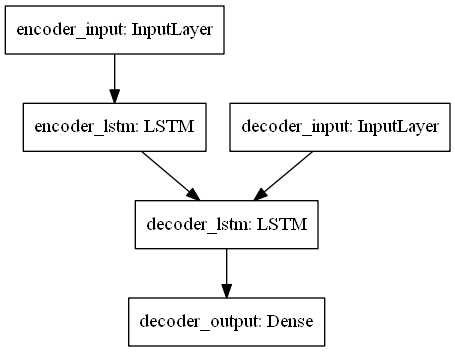

In [27]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='seq2seq_graph.png')
Image('seq2seq_graph.png')

In [29]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 21s 3ms/step - loss: 1.6115 - val_loss: 2.1379
Epoch 2/100
8000/8000 [==============================] - 18s 2ms/step - loss: 1.5364 - val_loss: 2.0804
Epoch 3/100
8000/8000 [==============================] - 18s 2ms/step - loss: 1.4820 - val_loss: 2.0133
Epoch 4/100
8000/8000 [==============================] - 19s 2ms/step - loss: 1.4247 - val_loss: 1.9843
Epoch 5/100
8000/8000 [==============================] - 18s 2ms/step - loss: 1.3634 - val_loss: 1.9221
Epoch 6/100
8000/8000 [==============================] - 18s 2ms/step - loss: 1.3163 - val_loss: 1.8967
Epoch 7/100
8000/8000 [==============================] - 18s 2ms/step - loss: 1.2729 - val_loss: 1.8691
Epoch 8/100
8000/8000 [==============================] - 18s 2ms/step - loss: 1.2274 - val_loss: 1.8395
Epoch 9/100
8000/8000 [==============================] - 18s 2ms/step - loss: 1.1879 - val_loss: 1.8233
Epoch 10/100
800

8000/8000 [==============================] - 18s 2ms/step - loss: 0.2161 - val_loss: 2.0785
Epoch 79/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.2105 - val_loss: 2.0993
Epoch 80/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.2043 - val_loss: 2.0900
Epoch 81/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.1988 - val_loss: 2.1056
Epoch 82/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.1944 - val_loss: 2.1079
Epoch 83/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.1946 - val_loss: 2.1131
Epoch 84/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.1870 - val_loss: 2.1257
Epoch 85/100
8000/8000 [==============================] - 19s 2ms/step - loss: 0.1785 - val_loss: 2.1276
Epoch 86/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.1738 - val_loss: 2.1371
Epoch 87/100
8000/8000 [==============================] - 18s 2ms/st

In [30]:
model.save('s2s.h5')

C:\Anaconda\lib\site-packages\keras\engine\topology.py:2344: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_lstm/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [33]:
import matplotlib.pyplot as plt 

def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()

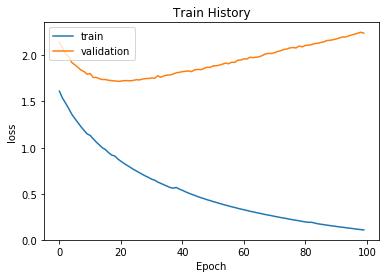

In [34]:
show_train_history(history, 'loss', 'val_loss')

# Model prediction

## Here's the drill:
1. Encode input and retrieve initial decoder state
2. Run one step of decoder with this initial state
   and a "start of sequence" token as target.
   Output will be the next target token
3. Repeat with the current target token and current states

![ex](https://imgur.com/b5z7vt0.png)

In [35]:
# Define sampling models

# Define the model of the encoder
encoder_model = Model(encoder_inputs, encoder_states)

# Define initial weight input for decoder LSTM cell
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Define the initial decoder state of the decoder
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs) # We use `decoder_states_inputs` as the initial state

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model of the decoder
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())

reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [36]:
# Decode the sequence
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    # In this example, the "\ t" character is used
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        
        # Exit condition: either hit max length or find stop characte
        # In this example, the "\n" character is used
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [37]:
%%time
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Hi.
Decoded sentence: 你好。

-
Input sentence: Hi.
Decoded sentence: 你好。

-
Input sentence: Run.
Decoded sentence: 你用跑的。

-
Input sentence: Wait!
Decoded sentence: 等等！

-
Input sentence: Hello!
Decoded sentence: 你好。

-
Input sentence: I try.
Decoded sentence: 讓我來。

-
Input sentence: I won!
Decoded sentence: 我贏了。

-
Input sentence: Oh no!
Decoded sentence: 不會吧。

-
Input sentence: Cheers!
Decoded sentence: 乾杯!

-
Input sentence: He ran.
Decoded sentence: 他跑了。

-
Input sentence: Hop in.
Decoded sentence: 跳進來。

-
Input sentence: I lost.
Decoded sentence: 我迷失了。

-
Input sentence: I quit.
Decoded sentence: 我退出。

-
Input sentence: I'm OK.
Decoded sentence: 我沒事。

-
Input sentence: Listen.
Decoded sentence: 聽著。

-
Input sentence: No way!
Decoded sentence: 沒門！

-
Input sentence: No way!
Decoded sentence: 沒門！

-
Input sentence: Really?
Decoded sentence: 你確定？

-
Input sentence: Try it.
Decoded sentence: 試試吧。

-
Input sentence: We try.
Decoded sentence: 我們會很忙。

-
Input sentence: Why

Reference:

[sequence-to-sequence learning in Keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)